In [1]:
import json
import getPSQLConn as psql
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sql_select = "SELECT id, code, content, definitions, content_tokens FROM ca_code;"
conn = psql.connect()
rows = psql.select_and_fetch_rows(conn, sql_select)
df = pd.DataFrame(rows, columns=["id", "Code", "Content", "Definitions", "Content_Tokens"])
df.index = df["id"]
df.sort_index(inplace=True)
df.head()


,id,Code,Content,Definitions,Content_Tokens
id,,,,,
0,0,CONS,ARTICLE I DECLARATION OF RIGHTS,,18
1,1,CONS,SECTION 1 All people are by nature free and in...,,47
2,2,CONS,SEC. 1.1 The state shall not deny or interfere...,,95
3,3,CONS,"SEC. 2 (a) Every person may freely speak, writ...",,361
4,4,CONS,SEC. 3 (a) The people have the right to instru...,,631


In [3]:
df.dtypes

id                 int64
Code              object
Content           object
Definitions       object
Content_Tokens     int64
dtype: object

In [4]:
df['Num_sentences'] = df.apply(lambda row: row.Content.count("."), axis = 1)
df['Len_Content'] = df.apply(lambda row: len(row.Content), axis=1)
df.describe()

,id,Content_Tokens,Num_sentences,Len_Content
count,178564.000000,178564.000000,178564.000000,178564.000000
mean,89288.068972,214.990188,6.334636,1007.692262
std,51552.629171,358.778947,39.053034,1918.395447
min,0.000000,0.000000,0.000000,0.000000
25%,44640.750000,58.000000,1.000000,205.000000
50%,89288.500000,111.000000,3.000000,447.000000
75%,133933.250000,214.000000,6.000000,1051.000000
max,178580.000000,8164.000000,8549.000000,201935.000000


In [5]:
import numpy as np
def get_bin_width(x):
    q25, q75 = np.percentile(x, [25, 75])
    bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
    bins = round((x.max() - x.min()) / bin_width)
    print("Freedman–Diaconis number of bins:", bins)
    return bins

In [6]:
from matplotlib.ticker import FormatStrFormatter
def plot_histogram_content_tokens(df,filename, cust_range=(0,8500), n_bins=10, useLog=False, density=False):
    fig, ax = plt.subplots()
    counts, bins, patches = ax.hist(df["Content_Tokens"],rwidth=0.9, color='#607c8e', range=cust_range,bins=n_bins, log=useLog, density=density)
    plt.xlabel("Tokens in Content")
    plt.ylabel("Count")
    plt.title("Tokens in range ({}, {})".format(cust_range[0], cust_range[1]))
    plt.grid(axis='y')
    
    
    ax.set_xticks(bins)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
    locs, labels = plt.xticks() #gets labels
    plt.setp(labels, rotation=90) #sets rotation of the labels
    plt.savefig("{}.png".format(filename))
    plt.show()

def plot_histogram_num_sentences(df, filename, cust_range=(0,150), n_bins=10, useLog=False, density=False):
    fig, ax = plt.subplots()
    counts, bins, patches = ax.hist(df["Num_sentences"],rwidth=0.9, color='#607c8e', range=cust_range,bins=n_bins, log=useLog, density=density)

    plt.xlabel("Number of Sentences")
    plt.ylabel("Count")
    plt.grid(axis='y')
    plt.title("Historgram of Sentences in Section")
    
    ax.set_xticks(bins)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
    locs, labels = plt.xticks() #gets labels
    plt.setp(labels, rotation=90) #sets rotation of the labels
    plt.savefig("{}.png".format(filename))
    plt.show()

Freedman–Diaconis number of bins: 73


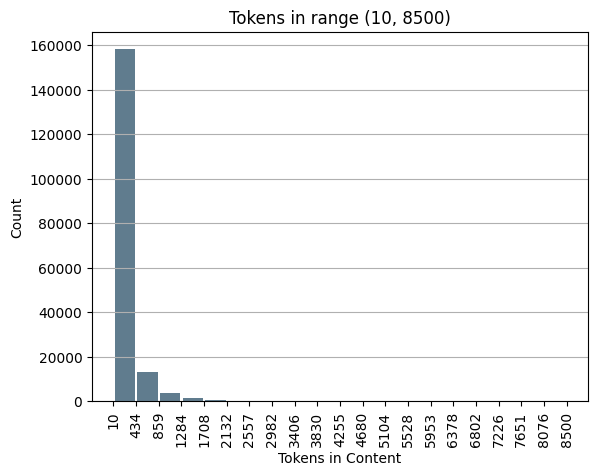

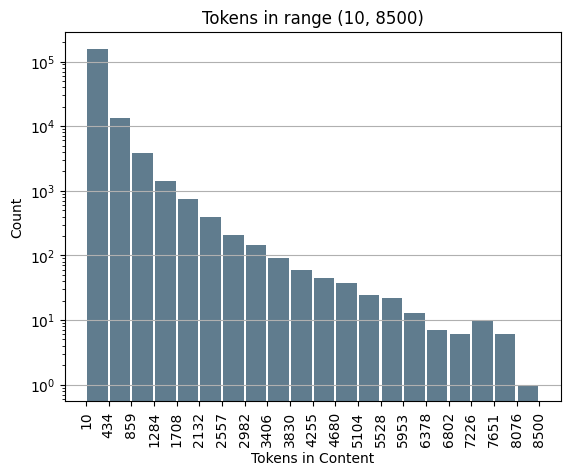

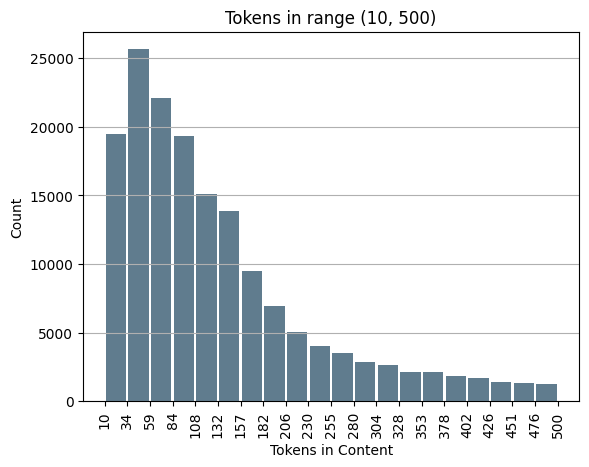

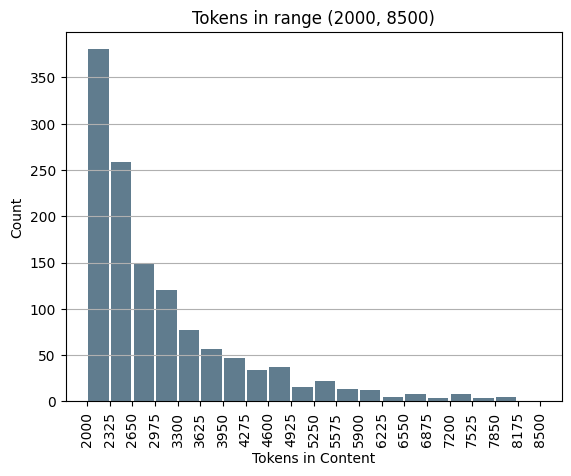

In [7]:
df_modified = df[df["Content_Tokens"]<250]
n_bins_hypothetical = get_bin_width(df_modified["Content_Tokens"])
plot_histogram_content_tokens(df, "token_distribution", cust_range=(10, 8500), n_bins=20, useLog=False, density=False)
plot_histogram_content_tokens(df, "log_token_distribution",cust_range=(10, 8500), n_bins=20, useLog=True, density=False)
plot_histogram_content_tokens(df, "main_token_distribution",cust_range=(10, 500), n_bins=20, useLog=False, density=False)
plot_histogram_content_tokens(df, "outlier_token_distribution",cust_range=(2000, 8500), n_bins=20, useLog=False, density=False)

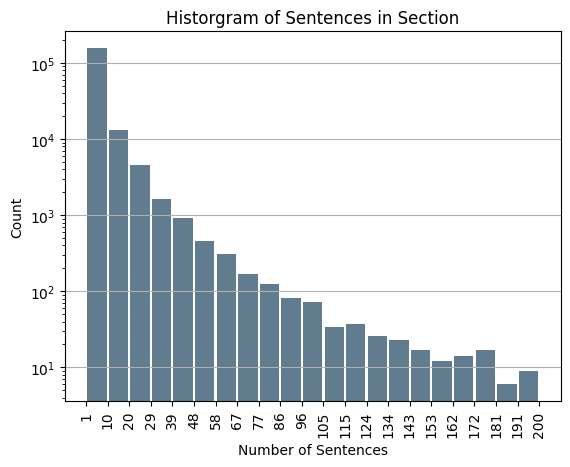

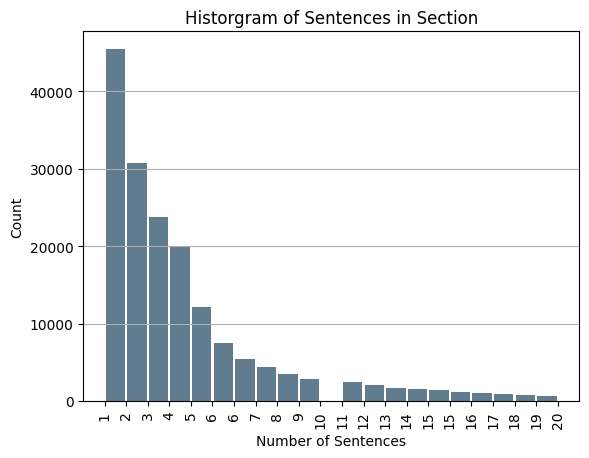

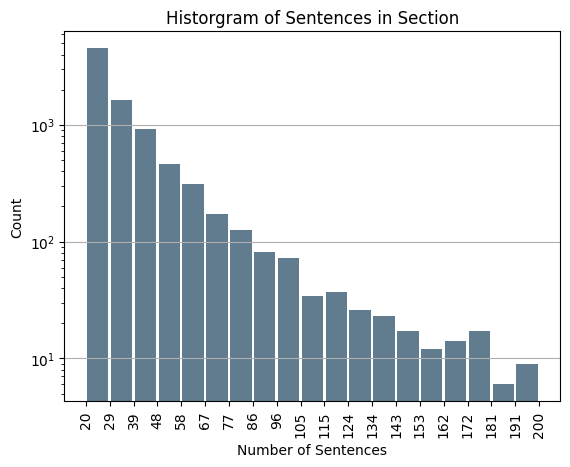

In [8]:
plot_histogram_num_sentences(df, "log_sentence_distribution", cust_range=(1, 200), n_bins=21, useLog=True, density=False)
plot_histogram_num_sentences(df, "main_sentence_distribution",cust_range=(1, 20), n_bins=21, useLog=False, density=False)
plot_histogram_num_sentences(df, "outlier_log_sentence_distribution",cust_range=(20, 200), n_bins=19, useLog=True, density=False)

In [9]:

def plot_sections_per_code(df, filename):
    df_grouped = df.groupby(df["Code"], as_index=False).count()
    df_grouped = df_grouped.sort_values("id", ascending=False) 
    plt.bar(df_grouped["Code"], df_grouped["id"])
    plt.xlabel("CA Codes")
    plt.ylabel("Count")
    plt.title("Count of unique sections per code")
    plt.grid(axis='y')
    locs, labels = plt.xticks() #gets labels
    plt.setp(labels, rotation=90) #sets rotation of the labels
    plt.savefig("{}.png".format(filename))
    plt.show()


def plot_tokens_per_code(df, filename):
    df_grouped = df.groupby("Code", as_index=False).agg({"Content_Tokens": sum})
    df_grouped = df_grouped.sort_values("Content_Tokens", ascending=False)  
    df_grouped["Content_Tokens"]/= 100000
    plt.bar(df_grouped["Code"], df_grouped["Content_Tokens"])
    plt.xlabel("CA Codes")
    plt.ylabel("100k Tokens")
    plt.title("Sum of All Tokens Per Code")
    plt.grid(axis='y')
    locs, labels = plt.xticks() #gets labels
    plt.setp(labels, rotation=90) #sets rotation of the labels
    plt.savefig("{}.png".format(filename))
    plt.show()

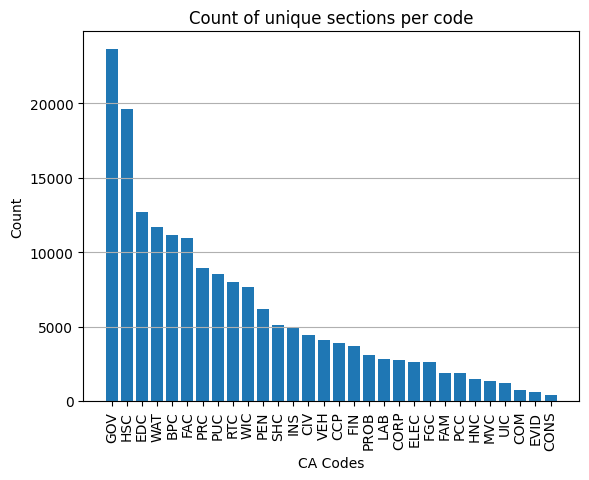

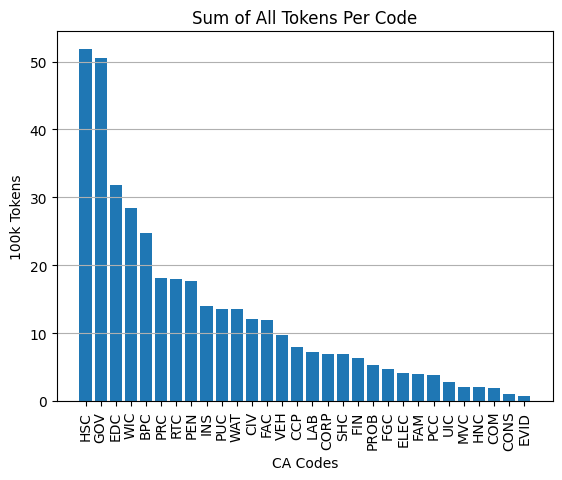

In [10]:
plot_sections_per_code(df, "section_code_distribution")
plot_tokens_per_code(df, "token_code_distribution")